To Do:
Warum funktioniert es mit dem Kreis nicht?
Vergleich zu FGSM
Try linear separation or very easy data

In [2]:
# Standard libraries

from torch.utils.data import DataLoader, TensorDataset
from models.resnets import ResNet
from models.neural_odes import NeuralODE, robNeuralODE, grad_loss_inputs
from models.training import Trainer, robTrainer, epsTrainer, epslinTrainer
from plots.plots import plt_classifier

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
import torch.nn as nn
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.colors import to_rgba
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import time
import imageio
import math
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Imports for plotting
%matplotlib inline
# For export. Makes the plots size right for the screen
set_matplotlib_formats('svg', 'pdf')
sns.set()

# Progress bar

# machine learning specific


# from plots.plots import visualize_classification, plt_classifier


# if training = False, models will be loaded from file


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)


/tmp/ipykernel_12148/972324870.py:29: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


In [30]:
# Plot variables

save_model = False  # train new network or load saved one
pretrained = False
num_epochs = 80  # 80 #number of optimization epochs for gradient decent

# model and training parameters

# epsilons = [0]
epsilons = [0 , 0.01,  0.1] #0.2, 0.5, 0.7]#, 0.01, 0.1, 0.5]#, 0.0001, 0.0002]#, 0.0001, 0.001, 0.01]
non_linearity = 'tanh'  # 'sigmoid' #'tanh'
architecture = 'inside'  # outside #bottleneck

# data
xornoise = 0.2
data_noise = 0.2 # 0.05 before


# plots
fig_name = '1alingen'
plot_steps = 0  # 0 means only one plot is generated. plot_steps >0 means each plot_steps epochs one plot is generated


# quite fixed
hidden_dim, data_dim = 2, 2
# 20 before  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5.0, 2
dt = T/num_steps
turnpike = False

bound = 0.
fp = False
cross_entropy = True

shuffle = False


if turnpike:
    weight_decay = 0 if bound > 0. else dt*0.01
else:
    weight_decay = dt*0.01  # 0.01 for fp, 0.1 else


In [31]:
import torch.utils.data as data


class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1, shift=torch.zeros(2, dtype=torch.float32)):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.shift = shift
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(
            self.size, 2), dtype=torch.float32)

        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.shift
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label


dataset = XORDataset(size=200, std=xornoise)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

shift = torch.Tensor([-.5, -.5])
train_dataset = XORDataset(size=2500, std=xornoise, shift=shift)
train_xor_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = XORDataset(size=500, std=xornoise, shift=shift)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_xor_loader = data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, drop_last=False)


Size of dataset: 200
Data point 0: (tensor([1.1601, 1.2507]), tensor(0))


In [32]:
from torch.autograd import Variable

def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted, _ = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels_predicted = model(dataset)
    ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.show()
    return fig, ax

    

In [33]:
@torch.no_grad()
def visualize_classification(model, data, label, grad, fig_name=None, footnote=None, contour = True, x1lims = [-2, 2], x2lims = [-2, 2]):
    
    x1lower, x1upper = x1lims
    x2lower, x2upper = x2lims

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(5, 4), dpi=300)
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0", zorder = 1)
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1", zorder = 1)

    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, -0.05, footnote, ha="center", fontsize=10)
    # plt.legend()

    for i in range(len(data[:, 0])):
        plt.arrow(data[i, 0], data[i, 1], grad[i, 0], grad[i, 1],
                  head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5)

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    # creates the RGB values of the two scatter plot colors.
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)

    

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds, _ = model(model_inputs)
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    # now we only want to have the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    # Specifying "None" in a dimension creates a new one. The rgb values hence get rescaled according to the prediction
    output_image = (1 - preds) * c1[None, None] + preds * c0[None, None]
    # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    output_image = output_image.cpu().numpy()
    plt.imshow(output_image, origin='lower', extent=(x1lower, x1upper, x2lower, x2upper), zorder = -1)
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])
    

    # labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.numpy()]
    if contour:
        z = np.array(preds).reshape(xx1.shape)
        plt.contourf(xx2, xx1, z, [0.3, 0.70], colors = ('w',), alpha = 0.3, zorder = 0)

    # preds_contour = preds.view(len(x1), len(x1)).detach()
    # plt.contourf(xx1, xx2, preds_contour, alpha=1)

    plt.savefig('test', bbox_inches='tight', dpi=300, format='png')
    return fig


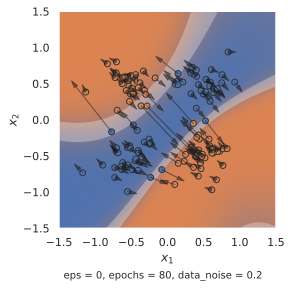

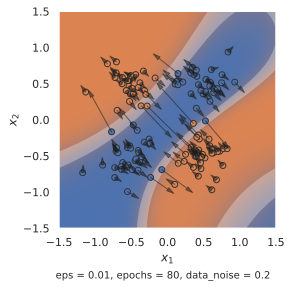

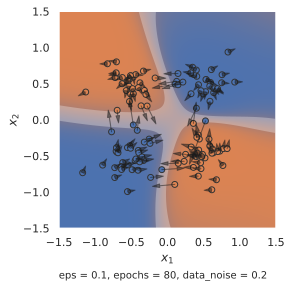

In [34]:
sort_num = 1

for eps in epsilons:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint=False, augment_dim=0, non_linearity=non_linearity,
                         architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))

    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(
    ), lr=1e-3, weight_decay=weight_decay)  # weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy=cross_entropy,
                                     turnpike=turnpike, bound=bound, fixed_projector=fp, verbose=False, eps=eps)

    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1, num_epochs+1, plot_steps)):

        trainer_eps_node.train(train_xor_loader, plot_steps)

        fig_name_plot = fig_name + \
            str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)

        for x_batch, y_batch in test_xor_loader:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10 * grad

            footnote = 'eps = {}, epochs = {}, data_noise = {}'.format(
                eps, num_epochs, xornoise)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote, x1lims = [-1.5, 1.5], x2lims = [-1.5, 1.5])
            # plot_decision_boundary(x_batch, y_batch, eps_node)
            plt.show()
            break
        sort_num += 1


In [38]:
###DATA PREPARATION
circ_noise = 0.1
X, y = make_circles(3000, noise=circ_noise, factor=0.15, random_state=1, shuffle = shuffle)
# X, y = make_moons(3000, noise = data_noise, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)



g = torch.Generator()
g.manual_seed(1)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle, generator=g)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=shuffle, generator = g)

1alingen1_0_0 created


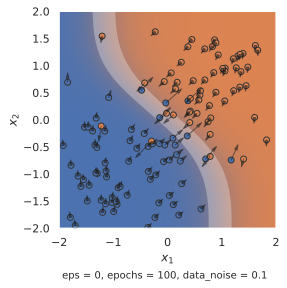

In [41]:
#MODEL INITIALIZITAION AND TRAINING

sort_num = 1

epsilons_circ = [0]#, 0.05, 0.1]
num_epochs = 100
non_linearity = 'tanh'
plot_steps = 0

num_steps = 5

pretrained = False
save_model = False


for eps in epsilons_circ:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1,num_epochs+1, plot_steps)):
    
        trainer_eps_node.train(dataloader, plot_steps)

        fig_name_plot = fig_name + str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)
        footnote = 'plot_count = {}, eps = {}, epochs = {}, data_noise = {}'.format(i, eps, num_epochs, data_noise)
        # plt_classifier(eps_node,  data_line, test, num_steps=10, trainer = trainer_eps_node, footnote = footnote, save_fig = '{}'.format(fig_name_plot) +'.png') 
        print('{} created'.format(fig_name_plot))

        for x_batch, y_batch in dataloader_viz:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10* grad
    
            footnote = ' eps = {}, epochs = {}, data_noise = {}'.format( eps, num_epochs, circ_noise)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote)
            plt.show()
            break
        sort_num += 1

if save_model:
        # torch.save(anode.state_dict(), 'anode.pth')
        torch.save(eps_node.state_dict(), 'rob_node.pth')

In [42]:
from sklearn.preprocessing import StandardScaler

centers = [[-1, -1], [1, 1]]
blob_std = 1

X, y = make_blobs(
    n_samples=750, centers=centers, cluster_std=blob_std, random_state=0
)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)



g = torch.Generator()
g.manual_seed(1)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle, generator=g)
dataloader_viz = DataLoader(test, batch_size=128, shuffle=shuffle, generator = g)

1alingen1_0_0 created


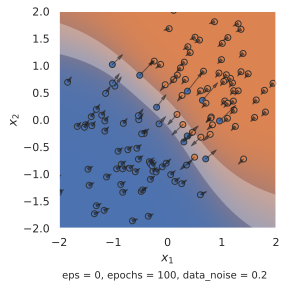

1alingen2_0p4_0 created


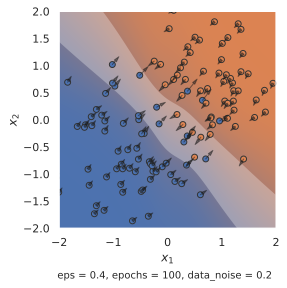

In [11]:
sort_num = 1

epsilons_class = [0, 0.4]
num_epochs = 100
non_linearity = 'tanh'
plot_steps = 0

num_steps = 5

pretrained = False
save_model = False


for eps in epsilons_class:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1,num_epochs+1, plot_steps)):
    
        trainer_eps_node.train(dataloader, plot_steps)

        fig_name_plot = fig_name + str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)
        footnote = 'plot_count = {}, eps = {}, epochs = {}, data_noise = {}'.format(i, eps, num_epochs, blob_std)
        # plt_classifier(eps_node,  data_line, test, num_steps=10, trainer = trainer_eps_node, footnote = footnote, save_fig = '{}'.format(fig_name_plot) +'.png') 
        print('{} created'.format(fig_name_plot))

        for x_batch, y_batch in dataloader_viz:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10* grad
    
            footnote = ' eps = {}, epochs = {}, data_noise = {}'.format( eps, num_epochs, data_noise)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote, x1lims = [-2, 2], x2lims = [-2,2], contour = True)
            plt.show()
            break
        sort_num += 1

if save_model:
        # torch.save(anode.state_dict(), 'anode.pth')
        torch.save(eps_node.state_dict(), 'rob_node.pth')

In [12]:
from sklearn.preprocessing import StandardScaler

centers = [[-1, -1], [1, 1]]
blob_std = 0.3

X, y = make_blobs(
    n_samples=750, centers=centers, cluster_std=blob_std, random_state=0
)

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)



g = torch.Generator()
g.manual_seed(1)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle, generator=g)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=shuffle, generator = g)

1alingen1_0_0 created


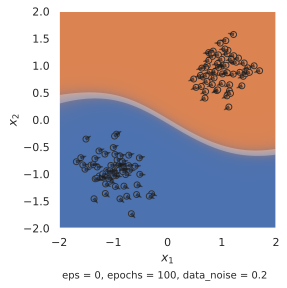

1alingen2_0p1_0 created


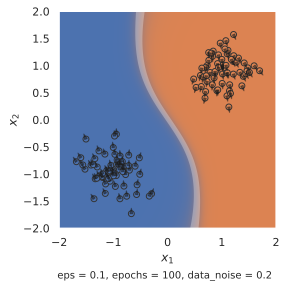

1alingen3_0p4_0 created


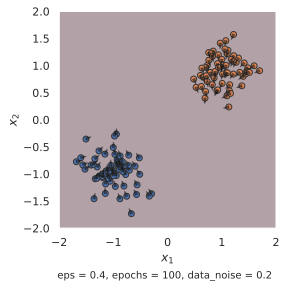

1alingen4_0p5_0 created


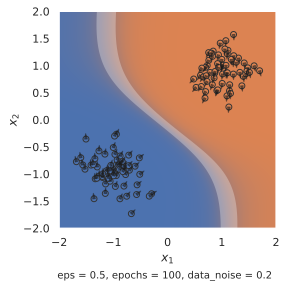

In [13]:
sort_num = 1

epsilons_class = [0, 0.1, 0.4, 0.5]
num_epochs = 100
non_linearity = 'tanh'
plot_steps = 0

num_steps = 5

pretrained = False
save_model = False


for eps in epsilons_class:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1,num_epochs+1, plot_steps)):
    
        trainer_eps_node.train(dataloader, plot_steps)

        fig_name_plot = fig_name + str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)
        footnote = 'plot_count = {}, eps = {}, epochs = {}, data_noise = {}'.format(i, eps, num_epochs, blob_std)
        # plt_classifier(eps_node,  data_line, test, num_steps=10, trainer = trainer_eps_node, footnote = footnote, save_fig = '{}'.format(fig_name_plot) +'.png') 
        print('{} created'.format(fig_name_plot))

        for x_batch, y_batch in dataloader_viz:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10* grad
    
            footnote = ' eps = {}, epochs = {}, data_noise = {}'.format( eps, num_epochs, data_noise)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote, x1lims = [-2, 2], x2lims = [-2,2], contour = True)
            plt.show()
            break
        sort_num += 1

if save_model:
        # torch.save(anode.state_dict(), 'anode.pth')
        torch.save(eps_node.state_dict(), 'rob_node.pth')